<a href="https://colab.research.google.com/github/vladimiralencar/DeepLearning-LANA/blob/master/CNN/CNN_tensorflow_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Abaixo você encontra um modelo de rede neural para o MNIST. 

Este Jupyter notebook é bastante longo, mas contém uma implementação completa de um modelo CNN com TensorFlow (não usamos o Keras aqui), explicado linha a linha.



In [1]:
# Carregando os dados
from google.colab import files
files.upload()
!mkdir images
!cp *.png images

Saving convolution.png to convolution.png
Saving network_flowchart.png to network_flowchart.png
mkdir: cannot create directory ‘images’: File exists


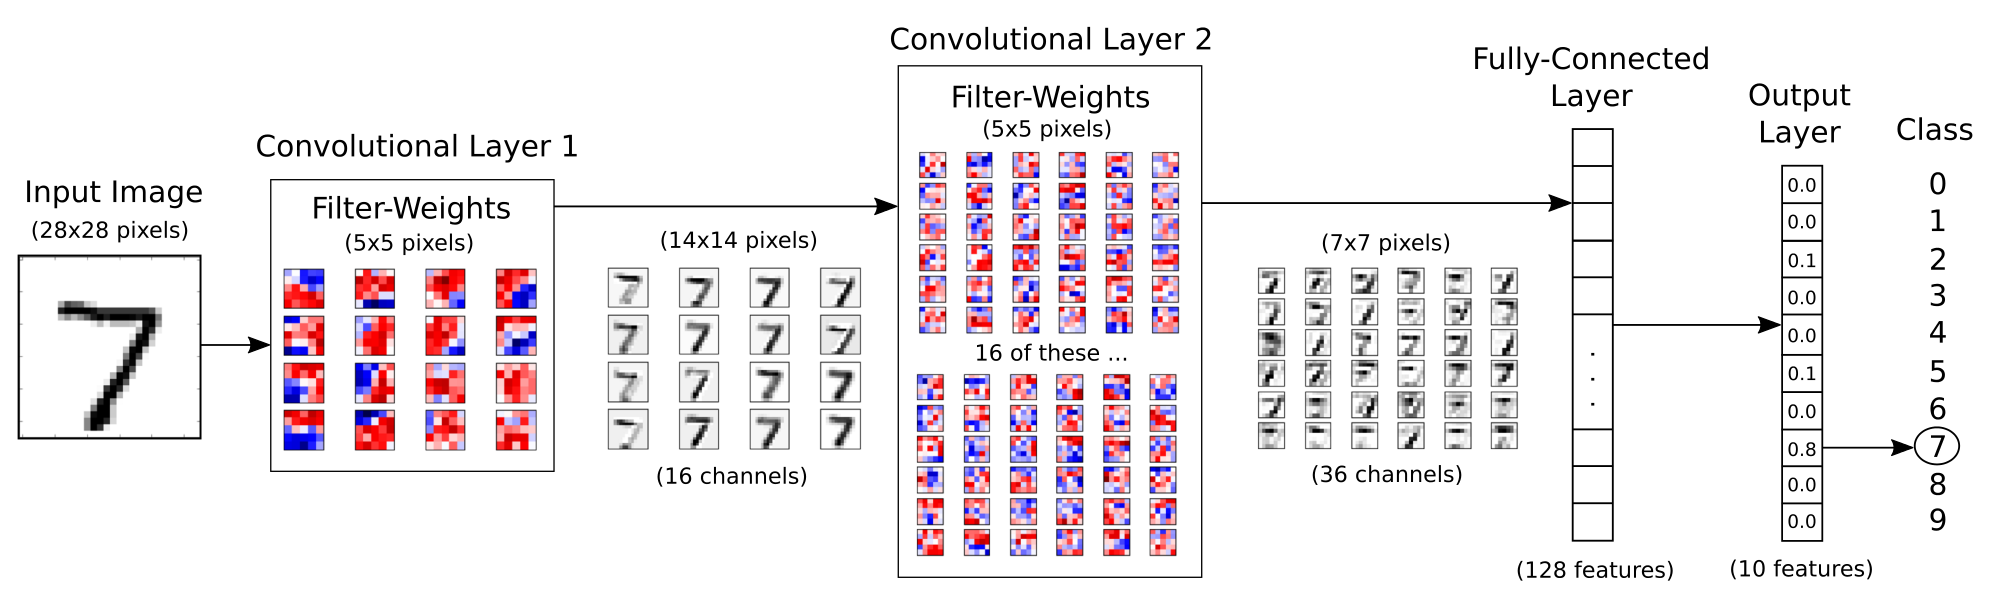

In [2]:
from IPython.display import Image
Image('images/network_flowchart.png')

Vamos começar descrevendo a arquitetura da CNN e revisando conceitos estudados ao longo deste capítulo. 

A imagem de entrada é processada na primeira camada convolucional usando os pesos de filtro. Considerando o número de filtros igual a 16, isso resulta em 16 novas imagens, uma para cada filtro na camada convolucional. As imagens também são reduzidas com a camada de Pooling reduzindo a imagem de 28x28 para 14x14.

Essas 16 imagens menores são então processadas na segunda camada convolucional. Precisamos de pesos de filtro para cada um desses 16 canais, e precisamos de pesos de filtro para cada canal de saída desta camada. Existem 36 canais de saída, portanto, há um total de 16 x 36 = 576 filtros na segunda camada convolucional. As imagens resultantes são reduzaidas novamente para 7x7 pixels.

A saída da segunda camada convolucional é de 36 imagens de 7x7 pixels cada. Estas são então achatados (flatten) para um único vetor de comprimento 7 x 7 x 36 = 1764, que é usado como entrada para uma camada totalmente conectada com 128 neurônios. Isso alimenta a outra camada totalmente conectada com 10 neurônios, uma para cada uma das classes, que é usada para determinar a classe da imagem, ou seja, qual número é representado na imagem.

Os filtros convolucionais são inicialmente escolhidos aleatoriamente, de modo que a classificação é feita aleatoriamente. O erro entre a classe predita e verdadeira da imagem de entrada é medido com a entropia cruzada. O otimizador então propaga esse erro automaticamente através da rede convolucional usando a cadeia de regras de diferenciação (chain rule) e atualiza os pesos de filtro de modo a reduzir o erro de classificação. Isso é feito iterativamente milhares de vezes até o erro de classificação ser suficientemente baixo.

Estes filtros-pesos e imagens intermediárias são os resultados de uma execução de otimização e podem parecer diferentes se você voltar a executar este Notebook.

Note-se que a computação no TensorFlow é realmente feita em um lote de imagens ao invés de uma única imagem, o que torna a computação mais eficiente. Isso significa que o fluxograma realmente possui mais uma dimensão de dados quando implementado no TensorFlow.

## Camada de Convolução

O diagrama a seguir mostra a ideia básica de processar uma imagem na primeira camada convolucional. A imagem de entrada representa o número 7 e quatro cópias da imagem são mostradas aqui, para que possamos ver mais claramente como o filtro está sendo movido para diferentes posições da imagem. Para cada posição do filtro, o dot product está sendo calculado entre o filtro e os pixels da imagem sob o filtro, o que resulta em um único pixel na imagem de saída. Então, mover o filtro em toda a imagem de entrada resulta em uma nova imagem que está sendo gerada.

Os pesos de filtro vermelhos significam que o filtro tem uma reação positiva aos pixels pretos na imagem de entrada, enquanto os pixels azuis significam que o filtro tem uma reação negativa aos pixels pretos.

Neste caso, parece que o filtro reconhece a linha horizontal do dígito 7, como pode ser visto a partir da sua reação mais forte a essa linha na imagem de saída.

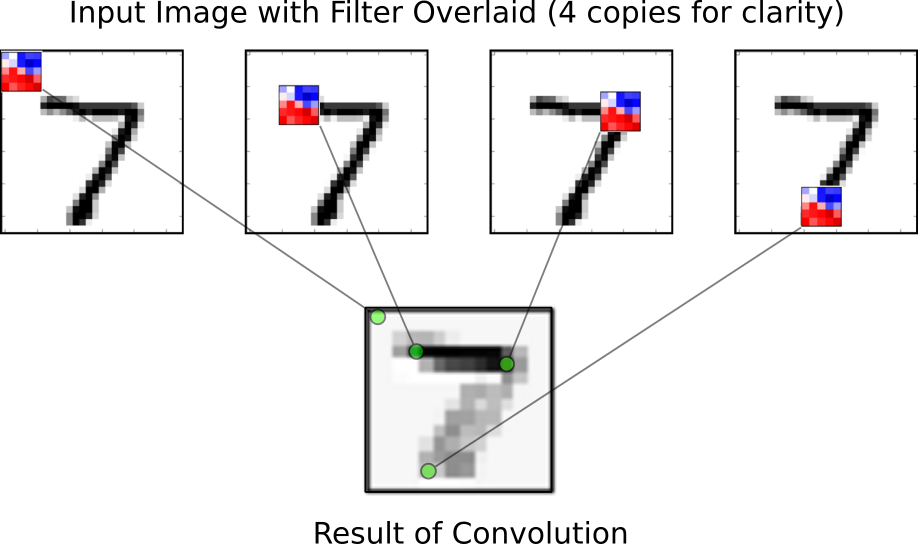

In [3]:
Image('images/convolution.png')

O step-size para mover o filtro através da entrada é chamado de passo (stride). Há um passo para mover o filtro horizontalmente (eixo x) e outro passo para se mover verticalmente (eixo y).

No código-fonte abaixo, o passo é definido como 1 em ambas as direções, o que significa que o filtro começa no canto superior esquerdo da imagem de entrada e está sendo movido 1 pixel para a direita em cada etapa. Quando o filtro atinge o final da imagem para a direita, o filtro é movido de volta para o lado esquerdo e 1 pixel para baixo da imagem. Isso continua até que o filtro tenha atingido o canto inferior direito da imagem de entrada e toda a imagem de saída tenha sido gerada.

Quando o filtro atinge o final do lado direito, bem como a parte inferior da imagem de entrada, ele pode ser preenchido com zero (pixels brancos). Isso faz com que a imagem de saída seja da mesma dimensão que a imagem de entrada.

Além disso, a saída da convolução pode ser passada através da chamada Unidade Linear Retificada (ReLU), que apenas garante que a saída seja positiva porque os valores negativos são ajustados para zero. A saída também pode ser avaliada pelo chamado Max Pooling, que considera pequenas janelas de 2x2 pixels e apenas mantém o maior desses pixels. Esta divide ao meio a resolução da imagem de entrada, isto é, de 28x28 para 14x14 pixels.

Observe que a segunda camada convolucional é mais complicada porque tem 16 canais de entrada. Queremos um filtro separado para cada canal de entrada, então precisamos de 16 filtros em vez de apenas um. Além disso, queremos 36 canais de saída da segunda camada convolucional, então, no total, precisamos de 16 x 36 = 576 filtros para a segunda camada convolucional. Pode ser um pouco desafiador entender como isso funciona, por isso você deve praticar tanto quanto possível.

## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

Esse código foi desenvolvido com Python 3.6 e TensorFlow:

In [5]:
tf.__version__

'1.12.0'

In [7]:
import sys
print(sys.version)
print(sys.version_info)

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)


## Configuração da Rede Neural

A configuração da Rede Neural Convolucional é definida aqui por conveniência, para que você possa encontrar e alterar esses números com facilidade e re-executar o Notebook.

In [0]:
## Camada Convolucional 1:

# Os filtros de convolução são 5 x 5 pixels.
filter_size1 = 5  

# Existem 16 desses filtros.
num_filters1 = 16        


## Camada Convolucional 2:

# Os filtros de convolução são 5 x 5 pixels.
filter_size2 = 5   

# Existem 36 desses filtros.
num_filters2 = 36        


## Camada Totalmente Conectada:

# Número de neurônios na camada totalmente conectada.
fc_size = 128            

## Carregando os Dados

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [11]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


Os rótulos de classe estão como One-Hot Encoding, o que significa que cada rótulo é um vetor com 10 elementos, todos os quais são zero exceto um elemento. O índice desse elemento é o número da classe, ou seja, o dígito mostrado na imagem associada. Também precisamos dos números de classe como números inteiros para o conjunto de teste, então nós o calculamos agora.

In [0]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Dimensões dos Dados

In [0]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

### Função Auxiliar Para o Plot de Imagens

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Plot de Algumas Imagens

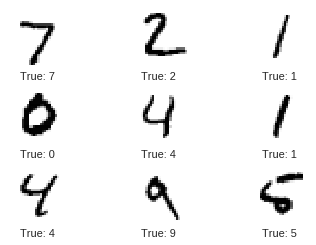

In [15]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true=cls_true)

## Grafo TensorFlow 

### Funções Auxiliares Para Criar Novas Variáveis (Pesos e Bias)

In [0]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [0]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Função Auxiliar Para Criar as Camadas Convolucionais

Esta função cria uma nova camada convolucional no grafo computacional para o TensorFlow. Nada é realmente calculado aqui, estamos apenas adicionando as fórmulas matemáticas ao grafo TensorFlow.

Assume-se que a entrada é um tensor 4-dim com as seguintes dimensões:

1. Número da imagem.
2. Eixo Y de cada imagem.
3. Eixo X de cada imagem.
4. Canais de cada imagem.

Observe que os canais de entrada podem ser canais de cores ou podem ser canais de filtro se a entrada for produzida a partir de uma camada convolucional anterior.

A saída é outro tensor 4-dim com as seguintes dimensões:

1. Número da imagem, igual à entrada.
2. Eixo Y de cada imagem. Se o agrupamento 2x2 for usado, a altura e a largura das imagens de entrada são divididas por 2.
3. Eixo X de cada imagem. Idem.
4. Canais produzidos pelos filtros convolucionais.

In [0]:
def new_conv_layer(input,              
                   num_input_channels, 
                   filter_size,        
                   num_filters,       
                   use_pooling = True): 

    # Shape do filtro/peso para a convolução. 
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Cria novos pesos
    weights = new_weights(shape = shape)

    # Cria o bias
    biases = new_biases(length = num_filters)

    # Cria a operação TensorFlow para convolução.
    # Observe que os passos (stride) estão configurados para 1 em todas as dimensões.
    # O primeiro e último passo deve ser sempre 1,
    # porque o primeiro é para o número da imagem e
    # o último é para o canal de entrada.
    # Mas, por exemplo, Strides = [1, 2, 2, 1] significaria que o filtro
    # é movido 2 pixels através dos eixos x e y da imagem.
    # O preenchimento (padding) está configurado para 'SAME', o que significa a imagem de entrada
    # é preenchida com zero nas bordas, então o tamanho da saída é o mesmo.
    layer = tf.nn.conv2d(input = input,
                         filter = weights,
                         strides = [1, 1, 1, 1],
                         padding = 'SAME')

    # Adiciona o bias ao resultado da convolução 
    layer += biases

    # Usando Pooling para reduzir o tamanho das imagens 
    if use_pooling:
        # Temos aqui um Max Pooling 2x2, o que significa que nós
        # consideramos janelas 2x2 e selecionamos o maior valor
        # em cada janela. Em seguida, movemos 2 pixels para a próxima janela.
        layer = tf.nn.max_pool(value = layer,
                               ksize = [1, 2, 2, 1],
                               strides = [1, 2, 2, 1],
                               padding = 'SAME')

    # Rectified Linear Unit (ReLU).
    # Calcula o max(x, 0) para cada pixel de entrada x.
    # Isso adiciona alguma não linearidade à fórmula e nos permite
    # aprender funções mais complicadas.
    layer = tf.nn.relu(layer)

    # Note que a ReLU é executada antes do Pooling.

    # Retornamos a camada resultante e os pesos de filtro porque vamos plotar os pesos mais tarde.
    return layer, weights

### Função Auxiliar Para "Achatar" (flatten) Uma Camada

A camada convolucional vai produzir um tensor de saída com 4 dimensões. Vamos adicionar camadas totalmente conectadas após as camadas de convolução, então precisamos reduzir o tensor 4-dim para 2-dim que pode ser usado como entrada para a camada totalmente conectada.

In [0]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()

    # O número de features é: img_height * img_width * num_channels
    # Podemos usar uma função do TensorFlow para calcular isso.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape da camada para [num_images, num_features].
    # Observe que acabamos de definir o tamanho da segunda dimensão
    # para num_features e o tamanho da primeira dimensão para -1
    # o que significa que o tamanho dessa dimensão é calculado
    # e o tamanho total do tensor é inalterado no reshape.
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

### Função Auxiliar Para Criar Uma Nova Camada Totalmente Conectada

Esta função cria uma nova camada totalmente conectada no grafo computacional para o TensorFlow. Nada é realmente calculado aqui, estamos apenas adicionando as fórmulas matemáticas ao grafo TensorFlow.

Supõe-se que a entrada é um tensor 2-dim de forma `[num_images, num_inputs]`. A saída é um tensor 2-dim de forma `[num_images, num_outputs]`.

In [0]:
def new_fc_layer(input,         
                 num_inputs,     
                 num_outputs,   
                 use_relu = True): 

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholders

Os placeholders servem como entrada para o grafo computacional TensorFlow que podemos alterar cada vez que executamos o grafo. Nós chamamos isso de alimentação das variáveis do espaço reservado e é demonstrado abaixo.

Primeiro, definimos a variável de espaço reservado para as imagens de entrada. Isso nos permite alterar as imagens que são inseridas no grafo TensorFlow. Este é chamado tensor, o que significa que é um vetor ou matriz multidimensional. O tipo de dados está configurado para `float32` e a forma é definida como ` [None, img_size_flat] `, onde ` None` significa que o tensor pode conter um número arbitrário de imagens com cada imagem sendo um vetor de comprimento `img_size_flat` .

In [0]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

As camadas convolutivas esperam que "x" seja codificado como um tensor 4-dim, então precisamos remodelá-lo para que sua forma seja `[num_images, img_height, img_width, num_channels]`. Note que `img_height == img_width == img_size` e `num_images` podem ser inferidos automaticamente usando -1 para o tamanho da primeira dimensão. Então, a operação de reshape é:

In [0]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Em seguida, temos a variável de espaço reservado para os rótulos verdadeiros associados às imagens que foram inseridas na variável de espaço reservado `x`. A forma desta variável de espaço reservado é `[None, num_classes]`, o que significa que pode conter um número arbitrário de rótulos e cada rótulo é um vetor de comprimento `num_classes` que é 10 neste caso.

In [0]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

Poderíamos também ter uma variável de espaço reservado para o número de classe, mas, em vez disso, calcularemos isso usando argmax. Observe que este é um operador TensorFlow, portanto, nada é calculado neste ponto.

In [24]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Camada Convolucional 1

Cria a primeira camada convolucional. É preciso `x_image` como entrada e cria `num_filters1` filtros diferentes, cada um com largura e altura iguais a `filter_size1`. Finalmente, desejamos tirar a amostra da imagem de forma que seja metade do tamanho, usando 2x2 max-pooling.

In [0]:
layer_conv1, weights_conv1 = new_conv_layer(input = x_image,
                                            num_input_channels = num_channels,
                                            filter_size = filter_size1,
                                            num_filters = num_filters1,
                                            use_pooling = True)

Verifique a forma do tensor que será emitido pela camada convolucional. É (?, 14, 14, 16), o que significa que existe um número arbitrário de imagens (isto é o "?"). Cada imagem tem 14 pixels de largura e 14 pixels de altura, e há 16 canais diferentes, um canal para cada um dos filtros.

In [26]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### Camada Convolucional 2

Cria a segunda camada convolucional, que recebe como entrada a saída da primeira camada convolucional. O número de canais de entrada corresponde ao número de filtros na primeira camada convolucional.

In [0]:
layer_conv2, weights_conv2 = new_conv_layer(input = layer_conv1,
                                            num_input_channels = num_filters1,
                                            filter_size = filter_size2,
                                            num_filters = num_filters2,
                                            use_pooling = True)

Verifique a forma do tensor que será emitido a partir desta camada convolucional. A forma é (?, 7, 7, 36) onde o "?" novamente significa que há um número arbitrário de imagens, com cada imagem com largura e altura de 7 pixels, e há 36 canais, um para cada filtro.

In [28]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

### Camada Flatten 

As camadas convolucionais produzem tensores 4-dim. Agora desejamos usá-los como entrada em uma rede totalmente conectada, o que requer que os tensores sejam remodelados ou "achatados" para tensores 2-dim.

In [0]:
layer_flat, num_features = flatten_layer(layer_conv2)

Verifique se os tensores agora têm forma (?, 1764), o que significa que há um número arbitrário de imagens que foram achatadas para vetores de comprimento 1764 cada. Observe que 1764 = 7 x 7 x 36.

In [30]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [31]:
num_features

1764

### Camada Totalmente Conectada 1

Adiciona uma camada totalmente conectada à rede. A entrada é a camada flatten. O número de neurônios ou nós na camada totalmente conectada é `fc_size`. ReLU é usado para que possamos aprender relações não-lineares.

In [0]:
layer_fc1 = new_fc_layer(input = layer_flat,
                         num_inputs = num_features,
                         num_outputs = fc_size,
                         use_relu = True)

Verifique se a saída da camada totalmente conectada é um tensor com forma (? 128) onde o "?" significa que há um número arbitrário de imagens e `fc_size` == 128.

In [33]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### Camada Totalmente Conectada 2

Adiciona outra camada totalmente conectada que executa vetores do comprimento 10 para determinar a quais das 10 classes a imagem de entrada pertence. Observe que o ReLU não é usado nesta camada.

In [0]:
layer_fc2 = new_fc_layer(input = layer_fc1,
                         num_inputs = fc_size,
                         num_outputs = num_classes,
                         use_relu = False)

In [35]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

### Classe Prevista

A segunda camada totalmente conectada estima a probabilidade de a imagem de entrada pertencer a cada uma das 10 classes. No entanto, essas estimativas são um pouco difíceis de interpretar porque os números podem ser muito pequenos ou grandes, então queremos normalizá-los para que cada elemento seja limitado entre zero e um e a soma de 10 elementos para um. Isso é calculado usando a chamada função softmax e o resultado é armazenado em `y_pred`.

In [0]:
y_pred = tf.nn.softmax(layer_fc2)

In [0]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

### Função de Custo a ser Otimizada

Para melhorar o modelo na classificação das imagens de entrada, devemos mudar de alguma forma as variáveis para todas as camadas da rede. Para fazer isso, primeiro precisamos saber o desempenho do modelo atualmente, comparando a saída prevista do modelo `y_pred` com a saída desejada `y_true`.

A entropia cruzada é uma medida de desempenho usada na classificação. A entropia cruzada é uma função contínua que é sempre positiva e, se a saída prevista do modelo corresponde exatamente à saída desejada, a entropia cruzada é igual a zero. O objetivo da otimização é, portanto, minimizar a entropia cruzada para que ela fique o mais próximo possível de zero ao alterar as variáveis das camadas de rede.

TensorFlow possui uma função incorporada para calcular a entropia cruzada. Observe que a função calcula o softmax internamente, então devemos usar a saída de `layer_fc2` diretamente em vez de` y_pred`, que já teve o softmax aplicado.

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = layer_fc2, labels = y_true)

Já calculamos a entropia cruzada para cada uma das classificações de imagens, de modo que temos uma medida de quão bem o modelo executa em cada imagem individualmente. Mas, para usar a entropia cruzada para orientar a otimização das variáveis do modelo, precisamos de um único valor escalar, então simplesmente tomamos a média da entropia cruzada para todas as classificações de imagem.

In [0]:
cost = tf.reduce_mean(cross_entropy)

### Método de Otimização

Agora que temos uma medida de custo que deve ser minimizada, podemos criar um otimizador. Neste caso, é o `AdamOptimizer` que é uma forma avançada de Gradient Descent.

Observe que a otimização não é realizada neste momento. Na verdade, nada é calculado, e estamos apenas adicionamos o otimizador-objeto ao gráfico TensorFlow para execução posterior.

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(cost)

### Medidas de Performance 

Precisamos de mais algumas medidas de desempenho para exibir o progresso do nosso modelo. Teremos aqui um vetor de booleanos se a classe prevista é igual à classe verdadeira de cada imagem.

In [0]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

Agora calculamos a precisão da classificação fazendo o cast do vetor de booleanos para floats, de modo que False se torna 0 e True se torna 1 e, em seguida, calculamos a média desses números.

In [0]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Cria a Sessão TensorFlow

In [0]:
session = tf.Session()

### Inicializando as Variáveis

In [0]:
session.run(tf.global_variables_initializer())

# Treinamento

Existem 55 mil imagens no conjunto de treinamento. Demora muito tempo calcular o gradiente do modelo usando todas essas imagens. Portanto, usamos apenas um pequeno lote de imagens em cada iteração do otimizador.

Se o seu computador falhar ou se tornar muito lento porque você está sem memória RAM, então você pode tentar diminuir esse número, mas talvez seja necessário executar mais iterações de otimização.

In [0]:
train_batch_size = 64

Função para executar uma série de iterações de otimização de modo a melhorar gradualmente as variáveis das camadas da rede. Em cada iteração, um novo lote de dados é selecionado a partir do conjunto de treinamento e, em seguida, TensorFlow executa o otimizador usando essas amostras de treinamento. O progresso é impresso a cada 100 iterações.

In [0]:
# Contagem do total de iterações
total_iterations = 0

def optimize(num_iterations):
    # Garante que a variável é global e não local
    global total_iterations

    # Start-time.
    start_time = time.time()

    for i in range(total_iterations, total_iterations + num_iterations):

        # Obtém um batch dos dados de treino
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Coloca o batch no placeholder
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Executa o otimizador
        session.run(optimizer, feed_dict = feed_dict_train)

        # Print
        if i % 100 == 0:
            # Calcula a acurácia
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Mensagem
            msg = "Iteração de Otimização: {0:>6}, Acurácia em Treino: {1:>6.1%}"

            # Print
            print(msg.format(i + 1, acc))

    # Atualiza o número total de iterações
    total_iterations += num_iterations

    # Fim da execução
    end_time = time.time()

    # Calcula o tempo gasto
    time_dif = end_time - start_time

    # Print
    print("Tempo gasto: " + str(timedelta(seconds=int(round(time_dif)))))

### Função Para Plot dos Erros

In [0]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    
    images = data.test.images[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = data.test.cls[incorrect]
    
    # Plot
    plot_images(images = images[0:9], cls_true = cls_true[0:9], cls_pred = cls_pred[0:9])

### Função Para Criar a Confusion Matrix

In [0]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls

    cm = confusion_matrix(y_true = cls_true, y_pred = cls_pred)

    # Print 
    print(cm)

    # Plot 
    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Previsto')
    plt.ylabel('Label Original')

    plt.show()

### Função Para Mostrar a Performance

Função para imprimir a precisão da classificação no conjunto de teste.

Demora um pouco para calcular a classificação para todas as imagens no conjunto de teste, é por isso que os resultados são reutilizados chamando as funções acima diretamente dessa função, portanto as classificações não precisam ser recalculadas por cada função.

Observe que esta função pode usar uma grande quantidade de memória do computador, razão pela qual o conjunto de testes é dividido em lotes menores. Se você tem pouca RAM no seu computador e ele travar, então você pode tentar baixar o tamanho do lote.

In [0]:
test_batch_size = 256

def print_test_accuracy(show_example_errors = False, show_confusion_matrix = False):

    num_test = len(data.test.images)

    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)

        images = data.test.images[i:j, :]

        labels = data.test.labels[i:j, :]

        feed_dict = {x: images, y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    cls_true = data.test.cls

    correct = (cls_true == cls_pred)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    # Print 
    msg = "Acurácia em Teste: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot 
    if show_example_errors:
        print("Erros:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot 
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance Antes da Otimização

In [51]:
print_test_accuracy()

Acurácia em Teste: 12.0% (1205 / 10000)


## Performance Após 1 Iteração de Otimização

In [52]:
optimize(num_iterations=1)

Iteração de Otimização:      1, Acurácia em Treino:  10.9%
Tempo gasto: 0:00:00


In [53]:
print_test_accuracy()

Acurácia em Teste: 10.1% (1011 / 10000)


## Performance Após 100 Iterações de Otimização

In [54]:
optimize(num_iterations = 99) 

Tempo gasto: 0:00:01


Acurácia em Teste: 67.3% (6727 / 10000)
Erros:


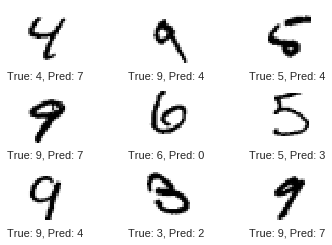

In [55]:
print_test_accuracy(show_example_errors=True)

## Performance Após 1000 Iterações de Otimização

In [56]:
optimize(num_iterations = 900)

Iteração de Otimização:    101, Acurácia em Treino:  59.4%
Iteração de Otimização:    201, Acurácia em Treino:  85.9%
Iteração de Otimização:    301, Acurácia em Treino:  84.4%
Iteração de Otimização:    401, Acurácia em Treino:  92.2%
Iteração de Otimização:    501, Acurácia em Treino:  92.2%
Iteração de Otimização:    601, Acurácia em Treino:  96.9%
Iteração de Otimização:    701, Acurácia em Treino:  92.2%
Iteração de Otimização:    801, Acurácia em Treino:  92.2%
Iteração de Otimização:    901, Acurácia em Treino:  98.4%
Tempo gasto: 0:00:04


Acurácia em Teste: 93.9% (9388 / 10000)
Erros:


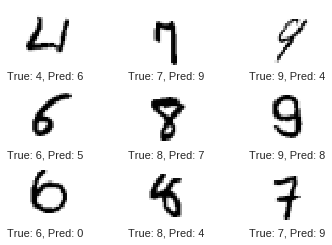

In [57]:
print_test_accuracy(show_example_errors=True)

## Performance Após 10.000 Iterações de Otimização

In [58]:
optimize(num_iterations = 9000) 

Iteração de Otimização:   1001, Acurácia em Treino:  95.3%
Iteração de Otimização:   1101, Acurácia em Treino:  96.9%
Iteração de Otimização:   1201, Acurácia em Treino:  95.3%
Iteração de Otimização:   1301, Acurácia em Treino:  96.9%
Iteração de Otimização:   1401, Acurácia em Treino:  98.4%
Iteração de Otimização:   1501, Acurácia em Treino:  98.4%
Iteração de Otimização:   1601, Acurácia em Treino:  96.9%
Iteração de Otimização:   1701, Acurácia em Treino:  96.9%
Iteração de Otimização:   1801, Acurácia em Treino:  96.9%
Iteração de Otimização:   1901, Acurácia em Treino:  95.3%
Iteração de Otimização:   2001, Acurácia em Treino:  98.4%
Iteração de Otimização:   2101, Acurácia em Treino:  96.9%
Iteração de Otimização:   2201, Acurácia em Treino:  98.4%
Iteração de Otimização:   2301, Acurácia em Treino:  98.4%
Iteração de Otimização:   2401, Acurácia em Treino:  96.9%
Iteração de Otimização:   2501, Acurácia em Treino:  95.3%
Iteração de Otimização:   2601, Acurácia em Treino:  93.

Acurácia em Teste: 98.9% (9888 / 10000)
Erros:


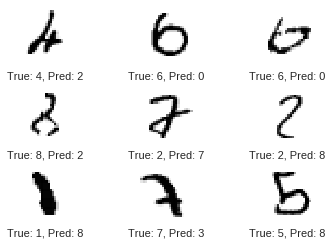

Confusion Matrix:
[[ 977    0    0    1    0    0    1    0    1    0]
 [   1 1124    1    0    0    0    4    2    3    0]
 [   3    0 1023    0    1    0    0    2    3    0]
 [   1    0    2 1002    0    3    0    0    2    0]
 [   0    0    1    0  976    0    0    0    0    5]
 [   2    1    0    5    0  882    1    0    1    0]
 [   4    1    1    0    2    5  945    0    0    0]
 [   1    1    7    2    0    0    0 1009    1    7]
 [   4    0    2    2    1    1    1    2  958    3]
 [   3    2    0    1    6    2    0    2    1  992]]


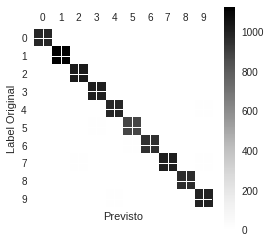

In [59]:
print_test_accuracy(show_example_errors = True, show_confusion_matrix = True)

## Visualização de Pesos e Camadas

Ao tentar entender por que a rede neural convolutiva pode reconhecer os dígitos manuscritos, agora visualizaremos os pesos dos filtros convolucionais e as imagens de saída resultantes.

### Função Para Plotar os Pesos Convolucionais

In [0]:
def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot 
    for i, ax in enumerate(axes.flat):
        if i < num_filters:

            img = w[:, :, input_channel, i]

            # Plot 
            ax.imshow(img, vmin = w_min, vmax = w_max, interpolation = 'nearest', cmap = 'seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Função Para o Plot das Saídas das Camadas Convolucionais

In [0]:
def plot_conv_layer(layer, image):

    feed_dict = {x: [image]}

    values = session.run(layer, feed_dict=feed_dict)

    num_filters = values.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = values[0, :, :, i]

            # Plot
            ax.imshow(img, interpolation = 'nearest', cmap = 'binary')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Input Images

In [0]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

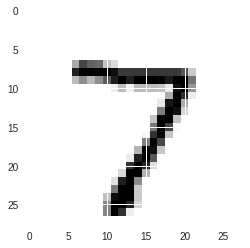

In [63]:
image1 = data.test.images[0]
plot_image(image1)

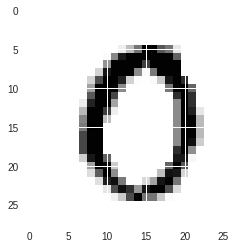

In [64]:
image2 = data.test.images[13]
plot_image(image2)

### Saídas da Camada Convolucional 1

Plot dos pesos de filtro para a primeira camada convolucional. Observe que os pesos positivos são vermelhos e os pesos negativos são azuis.

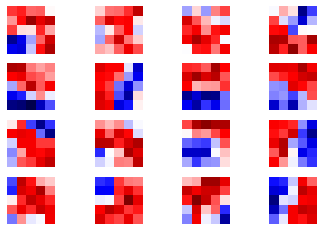

In [65]:
plot_conv_weights(weights=weights_conv1)

A aplicação de cada um desses filtros convolucionais na primeira imagem de entrada gera as seguintes imagens de saída, que são então utilizadas como entrada para a segunda camada convolucional. Observe que essas imagens são reduzudas para 14 x 14 pixels, metade da resolução da imagem de entrada original.

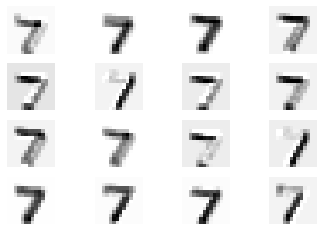

In [66]:
plot_conv_layer(layer = layer_conv1, image = image1)

As seguintes imagens são os resultados da aplicação dos filtros convolucionais à segunda imagem.

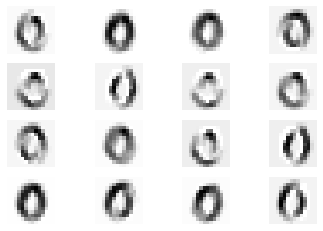

In [67]:
plot_conv_layer(layer=layer_conv1, image=image2)

É difícil ver nessas imagens quais os propósitos dos filtros convolucionais. Parece que eles simplesmente criaram várias variações da imagem de entrada, como se a luz estivesse brilhando de ângulos diferentes e lançando sombras na imagem.

### Saídas da Camada Convolucional 2

Plot dos pesos de filtro para a segunda camada convolucional.

Existem 16 canais de saída da primeira camada de convolução, o que significa que existem 16 canais de entrada para a segunda camada de convolução. A segunda conv-layer possui um conjunto de pesos de filtro para cada um dos seus canais de entrada. Começamos por plotar os pesos de filtro para o primeiro canal.

Note novamente que os pesos positivos são vermelhos e os pesos negativos são azuis.

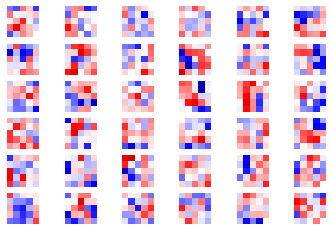

In [68]:
plot_conv_weights(weights = weights_conv2, input_channel = 0)

Existem 16 canais de entrada para a segunda camada convolucional, para que possamos fazer outros 15 lotes de pesos de filtro como este. Nós apenas fazemos mais um com o filtro de pesos para o segundo canal.

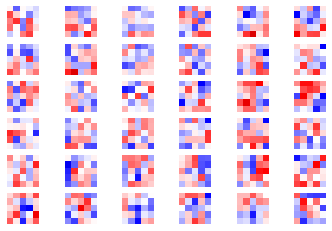

In [69]:
plot_conv_weights(weights = weights_conv2, input_channel = 1)

Pode ser difícil de entender e acompanhar a forma como esses filtros são aplicados por causa da alta dimensionalidade.

A aplicação desses filtros convolucionais às imagens que foram lançadas a partir da primeira camada convolucional fornece as seguintes imagens.

Note-se que as imagens estão ainda mais reduzidas pela camada de Max Pooling para 7 x 7 pixels, que é a metade da resolução das imagens da primeira camada de convolução.

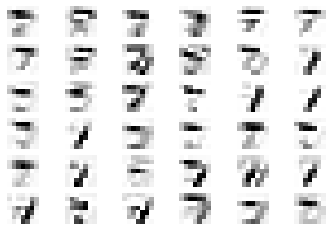

In [70]:
plot_conv_layer(layer=layer_conv2, image=image1)

E estes são os resultados da aplicação do filtro-pesos à segunda imagem.

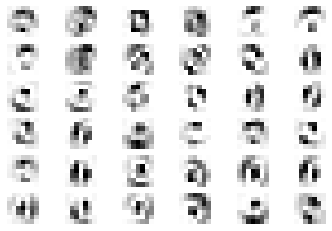

In [71]:
plot_conv_layer(layer=layer_conv2, image=image2)

A partir dessas imagens, parece que a segunda camada convolucional pode detectar linhas e padrões nas imagens de entrada, que são menos sensíveis às variações locais nas imagens de entrada originais.

Essas imagens são então "achatadas" e servem de entrada para a camada totalmente conectada.

### Encerrando a Sessão TensorFlow

In [0]:
session.close()

## Conclusão

A Rede Convolucional obtém uma precisão de classificação de cerca de 99%, ou mesmo mais se você fizer alguns ajustes, em comparação com apenas 91% para o modelo linear simples. No entanto, a rede convolutiva também é muito mais complicada de implementar, e não é óbvio, ao analisar os pesos de filtro, por que isso funciona e por que às vezes ele falha.